In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

music = pd.DataFrame()
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264,
                    205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                    164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24,
                    20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                    16, 18, 4, 23, 34, 19, 14, 11, 37, 42]
music['jazz'] = [1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
                0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
                1, 1, 1, 1, 0, 0, 1, 1, 0, 0]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Tuning KNN

While KNN is a relatively simple model, there are several things we can do to tune its performance. These primarily have to do with how we handle distance and how many neighbors we include.

## Distance and Normalizing

We've talked about the distance measure we use for deciding how close other observations are to a test point, but when we did so we glossed over some important nuance in measuring distance. Specifically, the measurement makes the assumption that all units are equal. So, in our previous example, being 1 loudness unit away is equivalent to being 1 second away. This is intensely problematic and one of the main issues people have with KNN. Units are rarely equivalent, and discerning how to adjust that unequivalence is an abstract and touchy subject. This difficulty also makes binary or categorical variables nearly impossible to include in a KNN model. It really is best if they are continuous. 

It can be a more obvious challenge if you were dealing with something where the relative scales are strikingly different. For example, if you were looking at buildings and you have height in floors and square footage, you'd have a model that would really only care about square footage since distance in that dimension would be a far greater number of units than the number of floors.

To deal with this, typically data scientists will engage in something called __normalization__. Normalization is a way of taking these seemingly incommensurate measures and making them comparable. There are two main normalization techniques that are effective with KNN.

1. You can set the bounds of the data to 0 and 1, and then **rescale** every variable to be within those bounds (it may also be reasonable to do -1 to 1, but the difference is actually immaterial). This way every data point is measured in terms of its distance between the max and minimum of its category. This is best if the data shows a linear relationship, such that scaling to a 0 to 1 range makes logical sense. It is also best if there are known limits to the dataset, as those make for logical bounds for 0 and 1 for the rescaling.

2. You can also calculate how far each observation is from the mean, expressed in number of standard deviations: this is often called z-scores. Calculating z-scores and using them as your basis for measuring distance works for continuous data and puts everything in terms of how far from the mean (or "abnormal") it is.

Either of these techniques are viable for most situations and you'll have to use your intuition to see which makes the most sense. Mixing them, while possible, is usually a dangerous proposition.

## Weighting

There is one more thing to address when talking about distance, and that is weighting. In the vanilla version of KNN, all $k$ of the closest observations are given equal votes on what the outcome of our test observation should be. When the data is densely populated that isn't necessarily a problem. Particularly if there is variance in the measurement itself, not trying to draw information from small differences in distance can be wise.

However, sometimes the $k$ nearest observations are not all similarly close to the test. In that case it may be useful to weight by distance. Functionally this will weight by the inverse of distance, so that closer datapoints (with a low distance) have a higher weight than further ones.

SKLearn again makes this quite easy to implement. There is an optional weights parameter that can be used when defining the model. Set that parameter to "distance" and you will use distance weighting.

Let's try it below and see how it affects our model. In this example we'll also use the stats module from SciPy to convert our data to z-scores.

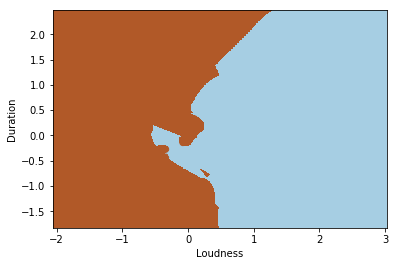

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

neighbors = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Our input data frame will be the z-scores this time instead of raw data.
X = pd.DataFrame({
    'loudness': stats.zscore(music.loudness),
    'duration': stats.zscore(music.duration)
})

# Fit our model.
Y = music.jazz
neighbors.fit(X, Y)

# Arrays, not data frames, for the mesh.
X = np.array(X)
Y = np.array(Y)

# Mesh size.
h = .01

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:,0].min() - .5
x_max = X[:,0].max() + .5
y_min = X[:,1].min() - .5
y_max = X[:,1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

This is a much more nuanced decision boundary, but it's also relatively continuous and consistent, providing a nice sense of which regions are likely to be which classification.


## Choosing K

The last major aspect of tuning KNN is picking $k$. This choice is largely up to the data scientist building the model but there are some things to consider.

Choosing $k$ is a tradeoff. The larger the $k$ the more smoothed out your decision space will be, with more observations getting a vote in the prediction. A smaller $k$ will pick up more subtle deviations, but these deviations could be just randomness and therefore you could just be overfitting. Add in weighting and that's an additional dimension to this entire conversation.

In the end, the best technique is probably to try multiple models and use your validation techniques to see which is best. In particular, k-fold cross validation is a great way to see how your KNN model is performing.

## DRILL:

Let's say we work at a credit card company and we're trying to figure out if people are going to pay their bills on time. We have everyone's purchases, split into four main categories: groceries, dining out, utilities, and entertainment. What are some ways you might use KNN to create this model? What aspects of KNN would be useful? Write up your thoughts in submit a link below.